## 掛接 Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tqdm import tqdm,trange
from keras.callbacks import ModelCheckpoint

## 載入資料

In [3]:
# 確認壓縮檔路徑
filepath='/content/drive/MyDrive/電腦視覺與深度學習/HW3/'
os.listdir(filepath)

['2022hw3.zip',
 'stanford_dogs',
 'category.xlsx',
 'sample_submission.csv',
 'prediction.csv',
 'MODEL.h5']

In [4]:
# # 解壓縮檔案
# !unzip '/content/drive/MyDrive/電腦視覺與深度學習/HW3/2022hw3.zip' -d '/content/drive/MyDrive/電腦視覺與深度學習/HW3/'

In [5]:
dirpath='/content/drive/MyDrive/電腦視覺與深度學習/HW3/stanford_dogs/stanfor_dogs/'
os.listdir(dirpath)

['test', 'train']

In [18]:
imgSize=(300,300)
imgShape=(300,300,3)
batchSize = 80

# train generator
trainDataGenerator = ImageDataGenerator(rescale = 1./255,
                      # samplewise_center = True,
                      # samplewise_std_normalization = True,
                      # rotation_range = 20,
                      width_shift_range=0.2,
                      height_shift_range=0.2,
                      horizontal_flip = True,
                      validation_split=0.3)

valDataGenerator = ImageDataGenerator(rescale=1/255,validation_split=0.3)

trainBatch = trainDataGenerator.flow_from_directory(
    directory = dirpath+'train',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = True,
    batch_size = batchSize,
    subset='training'
)

valBatch = valDataGenerator.flow_from_directory(
    directory = dirpath+'train',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = False,
    batch_size = batchSize,
    subset='validation'
)

# test generator
testDataGenerator = ImageDataGenerator(rescale=1/255)

testBatch = testDataGenerator.flow_from_directory(
    dirpath,
    class_mode='categorical',
    batch_size = batchSize,
    target_size= imgSize,
    shuffle = False,
    classes=['test']
)


Found 8400 images belonging to 120 classes.
Found 3600 images belonging to 120 classes.
Found 8580 images belonging to 1 classes.


## 載入模型

In [26]:
base_model = tf.keras.applications.ResNet152V2(
    include_top = False,
    weights = 'imagenet',
    input_tensor = None,
    input_shape=imgShape,
)

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
output_layer = layers.Dense(units = 120, activation = 'softmax')(x)

# 構建我們需要訓練的完整模型
model = tf.keras.Model(inputs = base_model.input, outputs = output_layer)

# 首先，我們只訓練頂部的幾層（隨機初始化的層）
# 鎖住所有 ResNet152V2 的捲積層
for layer in base_model.layers:
    layer.trainable = False

# 編譯模型（一定要在鎖層以後操作）
#model.compile(optimizer='adam', loss='categorical_crossentropy')

## train model

In [20]:
# 現在頂層應該訓練好了，讓我們開始微調 Inception V3 的捲積層。
# 我們會鎖住底下的幾層，然後訓練其餘的頂層。

# 讓我們看看每一層的名字和層號，看看我們應該鎖多少層呢：
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_4
1 conv1_pad
2 conv1_conv
3 pool1_pad
4 pool1_pool
5 conv2_block1_preact_bn
6 conv2_block1_preact_relu
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_pad
11 conv2_block1_2_conv
12 conv2_block1_2_bn
13 conv2_block1_2_relu
14 conv2_block1_0_conv
15 conv2_block1_3_conv
16 conv2_block1_out
17 conv2_block2_preact_bn
18 conv2_block2_preact_relu
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_pad
23 conv2_block2_2_conv
24 conv2_block2_2_bn
25 conv2_block2_2_relu
26 conv2_block2_3_conv
27 conv2_block2_out
28 conv2_block3_preact_bn
29 conv2_block3_preact_relu
30 conv2_block3_1_conv
31 conv2_block3_1_bn
32 conv2_block3_1_relu
33 conv2_block3_2_pad
34 conv2_block3_2_conv
35 conv2_block3_2_bn
36 conv2_block3_2_relu
37 max_pooling2d_9
38 conv2_block3_3_conv
39 conv2_block3_out
40 conv3_block1_preact_bn
41 conv3_block1_preact_relu
42 conv3_block1_1_conv
43 conv3_block1_1_bn
44 conv3_block1_1_relu
45 conv3_block1_2_pad
4

In [21]:
# 我們選擇訓練最上面的兩個 Inception block
# 也就是說鎖住前面249層，然後放開之後的層。
for layer in model.layers[:500]:
   layer.trainable = False
for layer in model.layers[500:]:
   layer.trainable = True

In [22]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 306, 306, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 150, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [29]:
# 在新的數據集上訓練幾代
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.005, decay=0.1), loss='categorical_crossentropy',metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/電腦視覺與深度學習/HW3/MODEL.h5", verbose=1, save_best_only=True,monitor='val_accuracy',mode='max')

In [30]:
epoch=50
history = model.fit(
  trainBatch,
  steps_per_epoch = trainBatch.samples // batchSize,
  validation_data = valBatch,
  validation_steps = valBatch.samples // batchSize,
  epochs=epoch,
  callbacks = checkpointer
)

Epoch 1/50
105/105 [==============================] - ETA: 0s - loss: 1.3422 - accuracy: 0.6423
Epoch 1: val_accuracy improved from -inf to 0.84556, saving model to /content/drive/My Drive/電腦視覺與深度學習/HW3/MODEL.h5
105/105 [==============================] - 194s 2s/step - loss: 1.3422 - accuracy: 0.6423 - val_loss: 0.5067 - val_accuracy: 0.8456
Epoch 2/50
105/105 [==============================] - ETA: 0s - loss: 0.7002 - accuracy: 0.7875
Epoch 2: val_accuracy improved from 0.84556 to 0.85583, saving model to /content/drive/My Drive/電腦視覺與深度學習/HW3/MODEL.h5
105/105 [==============================] - 184s 2s/step - loss: 0.7002 - accuracy: 0.7875 - val_loss: 0.4656 - val_accuracy: 0.8558
Epoch 3/50
105/105 [==============================] - ETA: 0s - loss: 0.6343 - accuracy: 0.8062
Epoch 3: val_accuracy improved from 0.85583 to 0.85722, saving model to /content/drive/My Drive/電腦視覺與深度學習/HW3/MODEL.h5
105/105 [==============================] - 185s 2s/step - loss: 0.6343 - accuracy: 0.8062 - va

## show the loss & accuracy curve

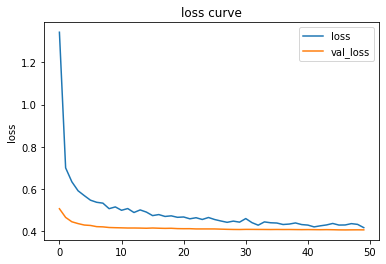

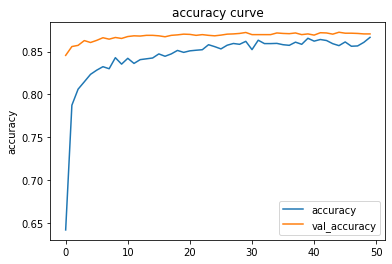

In [31]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## predict test data

In [32]:
prediction = model.predict(testBatch)
prediction

array([[6.50489881e-07, 1.24374463e-03, 3.00276763e-04, ...,
        4.61522234e-08, 3.58466832e-06, 4.90133175e-07],
       [8.39876247e-06, 9.98558462e-01, 6.18476648e-08, ...,
        4.61983618e-10, 2.43425742e-08, 8.24304447e-09],
       [1.32523397e-07, 1.08875696e-07, 1.23417763e-07, ...,
        8.52453113e-08, 1.78403127e-06, 4.07330344e-06],
       ...,
       [6.88252067e-06, 7.93300501e-08, 1.08099118e-06, ...,
        1.85179067e-06, 8.28260511e-07, 4.53775965e-06],
       [1.02272350e-06, 1.46912444e-05, 2.58232121e-05, ...,
        3.15388047e-06, 7.13546206e-06, 2.33744800e-06],
       [1.30092843e-07, 3.11931245e-07, 2.11356948e-07, ...,
        2.03445261e-08, 2.89857127e-07, 3.27469547e-06]], dtype=float32)

## 輸出結果

In [33]:
def deltest(x):
  x=str.split(x,"/")[1]
  return x

In [34]:
prediction_label=prediction.argmax(axis=1)
filename=testBatch.filenames
filename=list(map(deltest,filename))
outputdf=pd.DataFrame()
outputdf['Name']=filename
outputdf['Label']=prediction_label
outputdf.to_csv('/content/drive/MyDrive/電腦視覺與深度學習/HW3/prediction.csv',index=False)

In [35]:
# show the model stucture (截圖用)
model1 = tf.keras.Sequential([
    base_model,
    layers.Dropout(0.3),
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation = 'relu'),
    layers.Dropout(0.2),
    tf.keras.layers.Dense(120, activation="softmax")
])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 10, 10, 2048)      58331648  
                                                                 
 dropout_14 (Dropout)        (None, 10, 10, 2048)      0         
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 120)               61560     
                                                      

In [ ]:
from sklearn.metrics import confusion_matrix
pre=model.predict(trainBatch)
pre=np.argmax(pre,axis=1)

In [ ]:
import seaborn as sn
cm=confusion_matrix(pre,np.argmax(valBatch,axis=1))
fit=plt.figure(figsize=(8,6))
plt.title('confusion matrix')
sn.heatmap(cm,annot=True,cmap='OrRd',fmt='g')
plt.xlabel('prediction')
plt.ylabel('true label')
plt.show()

NameError: ignored